In [15]:
import sqlite3
import pandas as pd
from pandas import Timestamp, Period
from typing import Dict, Tuple
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import json

In [2]:
def connect_to_db(db_path: str) -> sqlite3.Connection:
    """Efficiently connect to SQLite database"""
    return sqlite3.connect(db_path, detect_types=sqlite3.PARSE_DECLTYPES)

def preprocess_datetime(df: pd.DataFrame) -> pd.DataFrame:
    """Central datetime preprocessing to reduce redundant operations"""
    datetime_columns = ['创建时间', '预定日期', '下单时间']
    for col in datetime_columns:
        if col in df.columns:
            if not pd.api.types.is_datetime64_any_dtype(df[col]):
                df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

def calculate_user_intervals(orders_df: pd.DataFrame) -> pd.DataFrame:
    """计算用户订单间隔"""
    orders_df['上次下单日期'] = orders_df.groupby('会员号')['创建时间'].shift(1)
    orders_df['order_interval'] = (orders_df['创建时间'] - orders_df['上次下单日期']).dt.days
    return orders_df

In [3]:
def get_db_connection():
    conn = sqlite3.connect('db/ideapod.db')
    conn.row_factory = sqlite3.Row
    return conn

In [13]:
def analyze_users(space_df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    # 设置时间范围
    today = space_df['创建时间'].max()
    begin_day = today - timedelta(days=180)  # 统计关注6个月的用户
    # 过滤过去6个月的数据
    df_filtered = space_df[space_df['创建时间'] >= begin_day].copy()
    
    # 按会员号聚合计算所需指标
    rfm_analysis = df_filtered.groupby('会员号').agg({
        '创建时间': 'max',  # 最近一次消费时间
        '实付金额': 'sum',  # 总消费金额
        '订单编号': 'count'  # 消费次数
    }).reset_index()
    
    # 重命名列
    rfm_analysis.columns = ['会员号', '最近消费时间', '总消费金额', '消费次数']
    rfm_analysis['Recency'] = (today - rfm_analysis['最近消费时间']).dt.days
    # 计算指数: e^(-λ * Recency), λ=0.015
    lambda_param = 0.015
    rfm_analysis['最近购买时间指数'] = np.exp(-lambda_param * rfm_analysis['Recency'])
    
    # 2. 计算Monetary指数
    rfm_analysis['消费力指数'] = np.log(rfm_analysis['总消费金额'] + 1)
    
    # 3. 计算Frequency指数
    rfm_analysis['消费频率指数'] = np.log(1 + rfm_analysis['消费次数'])

    result = rfm_analysis[['会员号', '最近购买时间指数', '消费力指数', '消费频率指数']]
    
    return {
        'RFM分析_bar': result
    }

In [33]:
def analyze(conn):
    space_df = pd.read_sql_query("SELECT * FROM Space", conn)
    member_df = pd.read_sql_query("SELECT 会员号, 等级 FROM Member", conn)

    space_df = space_df.merge(member_df, on='会员号', how='left')
    space_df['等级'] = space_df['等级'].astype(str)
    space_df['等级'] = space_df['等级'].fillna('未注册用户')
    space_df['等级'] = space_df['等级'].replace({'2.0': '关联户', '1.0': '微信注册用户', 'nan': '未注册用户'})
    space_df = space_df[space_df['等级'] != '0.0']

    space_df['订单商品名'] = space_df['订单商品名'].fillna('').str.replace('上海洛克外滩店-', '').str.replace('the Box', '')
    space_df['订单商品名'] = space_df['订单商品名'].apply(
        lambda x: '图书馆专注区' if x == '图书馆专注' else x
    )
    # 预处理数据，不填充数值列的 NaN，保留为 None
    space_df = preprocess_datetime(space_df)
    space_df['booking_month'] = space_df['创建时间'].dt.to_period('M')
    space_df['开始使用时刻'] = pd.to_datetime(space_df['预定开始时间'], errors='coerce').dt.hour
    results = analyze_users(space_df)

    return results

In [34]:
print (analyze(get_db_connection()))

             会员号   订单商品名          手机号  参会人数  预定备注  预定时长  实际时长  加钟数  \
311  13001025211  图书馆专注区  13001025211     1  None   3.0   1.0  0.0   
312  13001025211  心流舱·巴赫  13001025211     1  None   3.0   1.0  0.0   

               预定开始时间            预定结束时间  ... 是否发票申请  是否开具                创建时间  \
311  2025-01-03 15:00  2025-01-03 18:00  ...   None  None 2025-01-03 12:34:00   
312  2025-01-03 15:00  2025-01-03 18:00  ...   None  None 2025-01-03 12:31:00   

                修改者          修改时间  升舱   经办人     等级  booking_month  开始使用时刻  
311  administrators  1/3/25 12:45   否  None  未注册用户        2025-01      15  
312  administrators  1/3/25 12:45   否  None  未注册用户        2025-01      15  

[2 rows x 35 columns]


In [23]:
def plot_histogram(data: dict, key: str, column: str, title: str = None):
    df = data[key]  # 从字典中提取 DataFrame
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(title if title else f'Histogram of {column}')
    plt.grid(True, alpha=0.3)
    plt.show()


{'RFM分析_bar':               会员号  最近购买时间指数     消费力指数    消费频率指数
0     13001025211  0.873716  0.000000  1.098612
1     13003296089  0.810584  4.836282  0.693147
2     13023111169  0.444858  5.198497  0.693147
3     13025481715  0.810584  3.650658  0.693147
4     13027106168  0.120633  0.000000  0.693147
...           ...       ...       ...       ...
2204  91330026726  0.941765  5.771441  0.693147
2205  91330026849  0.985112  0.000000  0.693147
2206    919496737  0.847894  3.650658  0.693147
2207    963299731  0.160414  5.993961  0.693147
2208    987190206  0.847894  3.650658  0.693147

[2209 rows x 4 columns]}
              会员号  最近购买时间指数  消费力指数    消费频率指数
0     13001025211  0.873716    0.0  1.098612
4     13027106168  0.120633    0.0  0.693147
7     13036795426  0.637628    0.0  0.693147
8     13039043825  0.472367    0.0  0.693147
10    13062872632  0.565525    0.0  0.693147
...           ...       ...    ...       ...
2158  91330026454  0.970446    0.0  0.693147
2166  91330026489  0.927

/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36817 (\N{CJK UNIFIED IDEOGRAPH-8FD1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36141 (\N{CJK UNIFIED IDEOGRAPH-8D2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20080 (\N{CJK UNIFIED IDEOGRAPH-4E70}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Yixin/Documents/Projects/math-env/lib/python3.13/

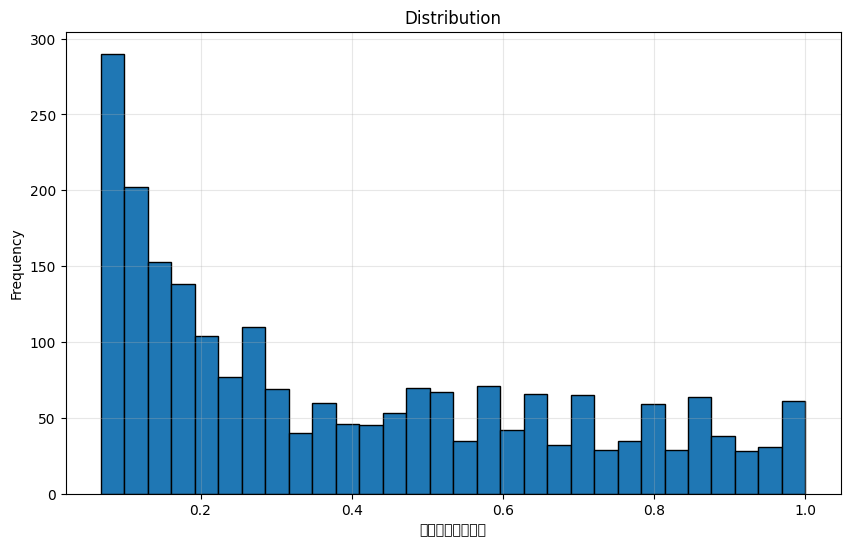

/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28040 (\N{CJK UNIFIED IDEOGRAPH-6D88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36153 (\N{CJK UNIFIED IDEOGRAPH-8D39}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


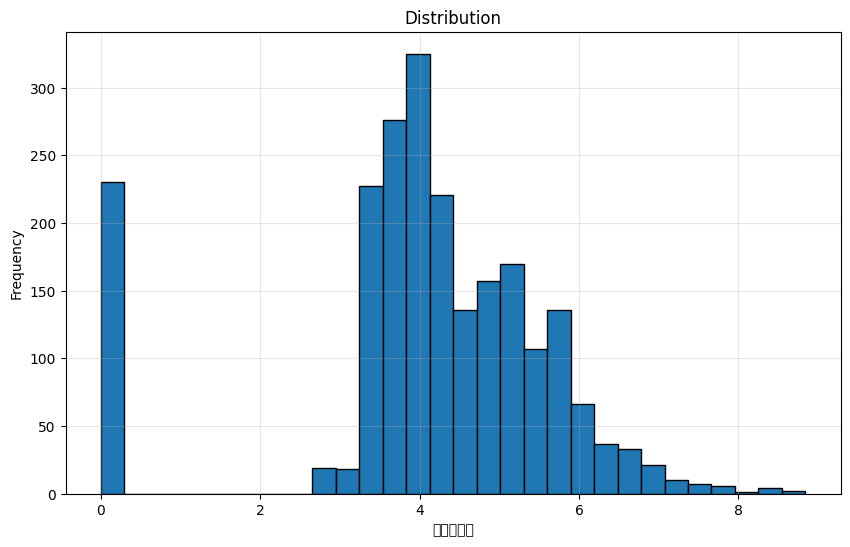

/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Yixin/Documents/Projects/math-env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


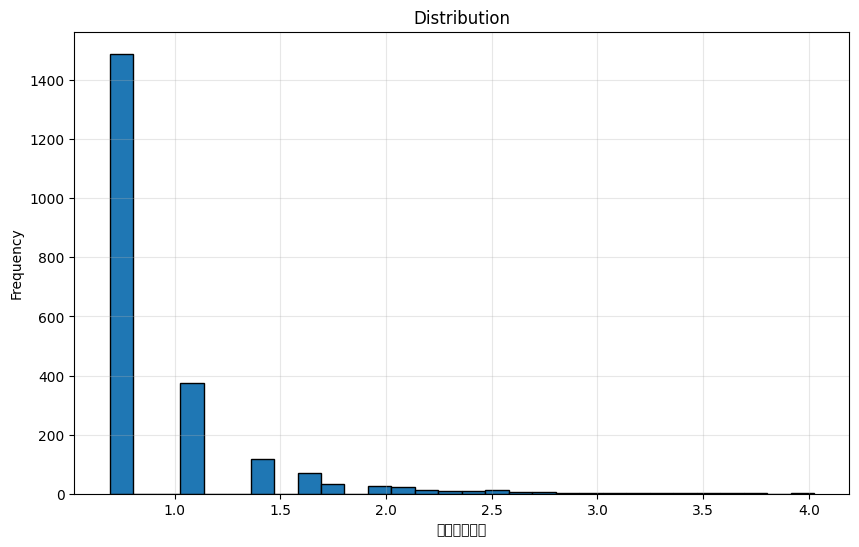

In [29]:
space_result = analyze(get_db_connection())
rfm_df = space_result ['RFM分析_bar']
check_result = rfm_df[rfm_df['消费力指数'] == 0]
print (space_result)
print (check_result)
plot_histogram(space_result, 'RFM分析_bar', '最近购买时间指数', 'Distribution')
plot_histogram(space_result, 'RFM分析_bar', '消费力指数', 'Distribution')
plot_histogram(space_result, 'RFM分析_bar', '消费频率指数', 'Distribution')